# Classification using pretrained, well-known models
This notebook aims to create a set of benchmarks for the project, using well-known, thoroughly studied models.
Either with pretrained weights, or training with new data.

## Notes
### 21.08.19
Attempting to classify with VGG has not proven effective yet.
Initially, the image data was note scaled at all. Implemented scaling in the
import function, using min-max scaling of the value. This preserves the inherent
intensity difference between images.

The number of layers of VGG16 used is varied between 3 to 9 without noticable
difference. Attempting to find out why, by analyzing the extracted features.
The idea is that in order to classify, the feature distribution should be
different for images containing single and double events.
I first attempt this with manual qualitative inspection.

Manual, qualitative inspection reveals that the distributions look very similar.
Performing a quantitative study using Kolmogorov-Smirnov two-sample test,
comparing the distribution for each feature.

* For 1 block (depth 3), the pvalue returned from comparisons is 1.0 for all features.
* For 2 blocks (depth 6), the pvalue returned from comparisons is 1.0 for all features.
* For 3 blocks (depth 10), the pvalue returned from comparisons is 1.0 for all features.
* For 4 blocks, (depth 14) the pvalue returned from comparisons is 1.0 for all features.
* For 5 blocks, (depth 18) the pvalue returned from comparisons is 1.0 for all features.

This indicates that extracting features using vgg16 doesn't work for classification.
I still want to confirm that the weights of the vgg layers are the imagenet weights.

### 22.08.19
Going to use a reference image from imagenet to verify that the vgg-layers behave
as expected.
* Reference produces very similar feature output as simulated data

Rewrote the vgg_model script to be able to import any pretrained model from
tensorflow, and extended data import to handle single files (for large file)
and possibility to specify number of samples to include.

### 23.08.19
Import scripts fixed so that array dimensions are correct independent of folder or single
file import.

Tests on multiple nets with 10k events give same results as for VGG.

### 24.08.19
Running checks on feature distribution with the full networks and 200k events.
With 200k events there are models which from the p-value given by the KS two-sample test
should be possible to classify with. Interstingly, VGG16 and VGG19 show a large variance in which
features are seemingly drawn from different distributions.

Need to run for: NASNetLarge, ResNet50 and Xception, but running into memory problems.

### 25.08.19
Some NaN values in output features from VGG. When removed, the network trains to acc = 0.9
on the features. 

Implemented save_feature_representation and load_feature_representation.

### 04.09.19
Storing 200k events to use for generating feature representations for classification.

### 09.09.19
Previously trained fully connected nets on the feature output from all pretrained networks available
at full depth. The fully-connected nets were configured so that the input layer had a number of nodes
equal to the number of features output from the convolutional block before it (because the input shape
must be defined). After that, two layers of 512 nodes with RELu actication functions, into one
2-node layer with softmax.
Results:
* __DenseNet121__: 
    Accuracy starts around 0.86 first epoch and rises to just under 0.94 at maximum.
    Somewhat unstable.
* __DenseNet169__: 
    Very similar to DenseNet121, but starts at around 0.90
* __DenseNet201__: 
    Very similar to other two DenseNets, but more stable above 0.92 for epoch 4+.
* __InceptionResNetV2__: 
    Starts at 0.84, maxes just above 0.88. A bit zig-zag.
* __InceptionV3__: 
    Similar to V2 above, but starts lower and maxes out higher (0.90). Huge dip at epoch 7,
    around same spot as DenseNets.
* __MobileNet__: 
    Didn't learn anything.
* __MobileNetV2__: 
    Didn't learn anything.
* __NASNetLarge__: 
    Starts at 0.88, maxes out at 0.92 ish. Stable nice increase in accuracy with small dip at last epoch.
* __NASNetMobile__: 
    Roughly same as NASNetLarge, but a little more zig-zag in the curve.
* __ResNet50__: 
    Didn't learn anything.
* __VGG16__: 
    A lot of zig-zag, but between 0.88 and just under 0.92 (max), so it's a small span.
    Stops zig-zagging on max and becomes pretty much flat.
* __VGG19__: 
    Smaller zig-zag distances, steady increase up to around 0.90 for maximum.
* __Xception__: 
    Starts high (0.88) and slowly rises to a maximum of 0.92, a dip around epoch 6 like many others.
    
From this I think the nets that didn't weren't able to extract anything from the features can be
ignored for a while, to focus on those that performed well. This leaves the following nets as possible
points of interest:
* DenseNet201 (best of the DenseNets, keep the others in mind)
* NASNetLarge (keep NASNetMobile in mind)
* VGG16
* VGG19
* Xception

### 15.09.19
Simple implementation of distance-checking of double events done.
Results indicate that the model struggles more with events that are close together.
Specifically, I've looked at the ratio of correctly classified double events where
the events are less than 3mm apart.

### 16.09.19
* Compare feature distributions of single events and double events with distance < 3mm.
Plots produced. There is a similar difference between single events and close double events,
as between single events and double events in general.

* Is the number of close events large enough to be confident in the result of the KS two-sample test?
* What does the above result imply?
* Is weighting the training data such that close events are weighted higher than others a good idea? Would this introduce a bias?

### 18.09.19
Producing histograms of correct vs wrong classifications for predictions on double events, specifically.
This gives additional insight in how well the models classify events, especially compared with the total
accuracy. An example is VGG16: The total accuracy for classification is around 0.88-0.92, but when looking
at event with a distance lower than 3mm between them, the ratio of correctly classified close events is 
around 0.4. Densenet201 full depth has comparable total accuracy, but a ratio for close events at 0.72, 
which is significantly better.

### 23.09.19
Distance calculations have been corrected. Relative energy implemented.
MobileNet and ResNet50 aren't able to learn anything

### 24.09.19
Produced and wrote about feature distribution comparisons.
Not done, but it's a start.

### 25.09.19
Implemented confusion matrix plotter (from scikit-learn's example)

## TODO:
* Implement functions to save and load trained fully-connected networks
* k-fold cross validation solves the problem with differences in training and test data.
* Plot events that are difficult. Perhaps try to find events that no networks can classify?
    * Can pass a set of indices along with data to train_test_split
* Confusion matrix plots
* F1-score?

## REDO:
* Should redo feature representations since the store "images_200k.npy" file seems to have had something happen to it



In [2]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import sys
import matplotlib.pyplot as plt
from master_data_functions.functions import import_data,save_feature_representation,load_feature_representation
from master_models.pretrained import pretrained_model
from master_data_functions.functions import event_indices, relative_distance, relative_energy
%load_ext autoreload
%autoreload 2

/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'

In [3]:

# File import
# Sample filenames are:
# CeBr10kSingle_1.txt -> single events, 
# CeBr10kSingle_2.txt -> single events
# CeBr10k_1.txt -> mixed single and double events 
# CeBr10.txt -> small file of 10 samples
# CeBr2Mil_Mix.txt -> 2 million mixed samples of simulated events

# Flag import, since we can now import 200k events from .npy files
from_file = False
if from_file:

    folder = "simulated"
    filename = "CeBr2Mil_Mix.txt"
    num_samples = 2e5
    #folder = "sample"
    #filename = "CeBr10k_1.txt"
    #num_samples = 1e3

    data = import_data(folder=folder, filename=filename, num_samples=num_samples)
    images = data[filename]["images"]
    energies = data[filename]["energies"]
    positions = data[filename]["positions"]
    labels = to_categorical(data[filename]["labels"])
    n_classes = labels.shape[1]
else:
    images = load_feature_representation("images_200k.npy")
    energies = load_feature_representation("energies_200k.npy")
    positions = load_feature_representation("positions_200k.npy")
    labels = load_feature_representation("labels_200k.npy")

n_classes = labels.shape[1]
print("Number of classes: {}".format(n_classes))
print("Images shape: {}".format(images.shape))
print("Energies shape: {}".format(energies.shape))
print("Positions shape: {}".format(positions.shape))
print("Labels shape: {}".format(labels.shape))


Number of classes: 2
Images shape: (200000, 16, 16, 1)
Energies shape: (200000, 2)
Positions shape: (200000, 4)
Labels shape: (200000, 2)


In [4]:
# VGG16 expects 3 channels. Solving this by concatenating the image data 
# to itself, to form three identical channels

images = np.concatenate((images, images, images), axis=3)
print("Image data shape: {}".format(images.shape))

Image data shape: (200000, 16, 16, 3)


## Classification with custom dense network
### Multiple dense model
Build a dense model for each pretrained model form which a feature representation has been saved.

In [5]:
# Keys: model names, Values: depth to compare at.
pretrained_models = {
    "DenseNet121":None, #8
    "DenseNet169":None, #8
    "DenseNet201":None, #8
    "InceptionResNetV2":None, #8
    "InceptionV3":None, #8
    "MobileNet":None, #8
    "MobileNetV2":None, #5
    "NASNetLarge":None, #4
    "NASNetMobile":None, #4
    "ResNet50":None, #8
    "VGG16":None,
    "VGG19":None,
    "Xception":None, #6
    }

#### Training, and plotting of accuracy and loss

In [ ]:
# Train multiple fully-connected networks to classify based on
# extracted features
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
    
# Set up and train a network for each of the pretrained features available    
for net, depth in pretrained_models.items():
    print("Running for:", net)
    
    # Load features
    if depth is None:
        depth = "full"
    features_filename = net + "_d" + str(depth) + "_" + str(images.shape[0]) + ".npy"
    pretrained_features = load_feature_representation(features_filename)
    model = Sequential()
    model.add(Dense(512, input_shape=pretrained_features.shape[1:]))
    model.add(Activation('relu'))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Remove nan values from pretrained_features (and remove labels which produces them)
    nan_indices = []
    for i in range(pretrained_features.shape[0]):
        if np.isnan(pretrained_features[i,:]).any():
            nan_indices.append(i)
    pretrained_features = np.delete(pretrained_features, nan_indices, axis=0)
    tmp_labels = np.delete(labels, nan_indices, axis=0)

    # Split the data into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(pretrained_features, tmp_labels, test_size = 0.2)    
    
    # Train the model
    history = model.fit(
        x_train, 
        y_train, 
        epochs=10, 
        batch_size=32,
        validation_data=(x_test, y_test))
    
    acc_filename = net + "_d" + str(depth) + "_" + str(pretrained_features.shape[0]) + "_accuracy"
    loss_filename = net + "_d" + str(depth) + "_" + str(pretrained_features.shape[0]) + "_loss"

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig(acc_filename)
    plt.clf()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig(loss_filename)
    plt.clf()
    


### Single dense model for one pretrained model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
# Single net testing

net = "DenseNet201"
depth = "full"
epochs = 5
# Load features
features_filename = net + "_d" + str(depth) + "_" + str(images.shape[0]) + ".npy"
pretrained_features = load_feature_representation(features_filename)
model = Sequential()
model.add(Dense(512, input_shape=pretrained_features.shape[1:]))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Remove nan values from pretrained_features (and remove labels which produces them)
nan_indices = []
for i in range(pretrained_features.shape[0]):
    if np.isnan(pretrained_features[i,:]).any():
        nan_indices.append(i)
pretrained_features = np.delete(pretrained_features, nan_indices, axis=0)
tmp_labels = np.delete(labels, nan_indices, axis=0)
tmp_positions = np.delete(positions, nan_indices, axis=0)
tmp_energies = np.delete(energies, nan_indices, axis=0)

labels_positions_energies = np.concatenate((tmp_labels, tmp_positions, tmp_energies), axis=1)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(pretrained_features, labels_positions_energies, test_size = 0.2)    

test_positions = y_test[:, 2:6]
train_positions = y_train[:, 2:6]
test_energies = y_test[:, 6:]
train_energies = y_train[:, 6:]
y_test = y_test[:, :2]
y_train = y_train[:, :2]

# Train the model
history = model.fit(
    x_train, 
    y_train, 
    epochs=epochs, 
    batch_size=32,
    validation_split=0.1)





W0925 20:24:54.678203 140078319314752 deprecation.py:323] From /home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 143998 samples, validate on 16000 samples
Epoch 1/5
143998/143998 [==============================] - 25s 171us/sample - loss: 0.3230 - accuracy: 0.8626 - val_loss: 0.3772 - val_accuracy: 0.8441
Epoch 2/5
143998/143998 [==============================] - 22s 152us/sample - loss: 0.2596 - accuracy: 0.8986 - val_loss: 0.2633 - val_accuracy: 0.8975
Epoch 3/5
143998/143998 [==============================] - 22s 150us/sample - loss: 0.2318 - accuracy: 0.9125 - val_loss: 0.2051 - val_accuracy: 0.9268
Epoch 4/5
143998/143998 [==============================] - 24s 170us/sample - loss: 0.2168 - accuracy: 0.9208 - val_loss: 0.2089 - val_accuracy: 0.9259
Epoch 5/5
143998/143998 [==============================] - 24s 163us/sample - loss: 0.2078 - accuracy: 0.9249 - val_loss: 0.1975 - val_accuracy: 0.9281


### Predict on test set and evaluate

In [7]:
tmp_predicted = model.predict(x_test)
tmp_results = tmp_predicted.argmax(axis=-1).reshape(tmp_predicted.shape[0], 1)

# indices, relative distances and relative energies for test set
single_indices, double_indices, close_indices = event_indices(test_positions)
rel_distance = relative_distance(test_positions)
rel_energy = relative_energy(test_energies)



Confusion matrix, without normalization
[[20051    53]
 [ 2773 17123]]


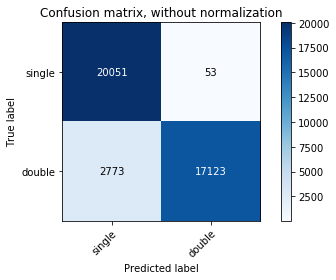

In [8]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
from analysis_functions.plotting import plot_confusion_matrix
classes = ["single", "double"]
plot_confusion_matrix(y_test.argmax(axis=-1), tmp_results, classes)

In [ ]:
correct_doubles = np.where(tmp_results[double_indices] == 1)[0]
print(len(np.where(rel_energy[double_indices] != -100)[0]))
print(len(np.where(rel_energy[double_indices][correct_doubles] == -100)[0]))

In [ ]:
# Separate correct and wrong classifications


correct_doubles = np.where(tmp_results[double_indices] == 1)[0]
wrong_doubles = np.where(tmp_results[double_indices] == 0)[0]

mean_correct = np.mean(rel_distance[double_indices][correct_doubles])
mean_wrong = np.mean(rel_distance[double_indices][wrong_doubles])
mean_all = np.mean(rel_distance[double_indices])

ratio_doubles = len(correct_doubles) / len(double_indices)

# Ratio of correctly classified double events with a distance between
# events < 3mm
n_close = len(close_indices)
n_close_correct = len(np.where(rel_distance[double_indices][correct_doubles] < 3.0)[0])
ratio_close = n_close_correct / n_close
print(len(correct_doubles))
print(len(wrong_doubles))

# Output
print("Mean dist all double events: ", mean_all)
print("Mean dist correct double events: ", mean_correct)
print("Mean dist wrong double events: ", mean_wrong)
print("Ratio of correctly classified double events: ", ratio_doubles)
print("Ratio correctly classified events with dist < 3mm: ", ratio_close)


In [ ]:
# Histograms
dist_bins = np.arange(0, np.amax(rel_distance), 0.5)
energy_bins = np.arange(0, np.amax(rel_energy), 0.02)
fig, ax = plt.subplots(2, 2, figsize=(12,8))
ax[0,0].hist(rel_distance[double_indices][correct_doubles], bins=dist_bins, alpha=0.5, label="correct")
ax[0,0].hist(rel_distance[double_indices][wrong_doubles], bins=dist_bins, alpha=0.5, label="wrong")
ax[0,0].set_title("Relative distance")
ax[0,0].legend()
ax[0,1].hist(rel_energy[double_indices][correct_doubles], bins=energy_bins, alpha=0.5, label="correct")
ax[0,1].hist(rel_energy[double_indices][wrong_doubles], bins=energy_bins, alpha=0.5, label="wrong")
ax[0,1].set_title("Relative energy")
ax[0,1].legend()
ax[1,0].hist(rel_distance[double_indices], bins=50)
ax[1,0].set_title("Distribution of relative distances")
ax[1,1].hist(rel_energy[double_indices], bins=50)
ax[1,1].set_title("Distribution of relative energies")



## Plot examples of events that are ~always misclassified

In [ ]:
indices = []
for index in wrong_doubles:
    if index in close_indices:
        indices.append(index)


img_plot = images.reshape(images.shape[0], 16, 16)
fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))

index = 0
for i in range(3):
    for j in range(3):
        # plot image
        ax[i, j].imshow(img_plot[indices[i*3 + j]])
        
        # plot origin of event
        x = test_positions[indices[index + i*3 + j], 0]
        y = test_positions[indices[index + i*3 + j], 1]
        ax[i, j].plot(x, y, 'rx')
        ax[i, j].set_title('single')
        if test_positions[indices[index + i*3 + j], 3] != -100:
            x2 = test_positions[indices[index + i*3 + j], 2]
            y2 = test_positions[indices[index + i*3 + j], 3]
            ax[i, j].plot(x2, y2, 'rx')
            ax[i, j].set_title('double')
        

In [ ]:
# Plot some images, with electron origin positions
%matplotlib inline

images = images.reshape(images.shape[0],16,16)

fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))
for i in range(3):
    for j in range(3):
        # plot image
        ax[i, j].imshow(images[index + i*3 + j])
        
        # plot origin of event
        x = positions[index + i*3 + j, 0]
        y = positions[index + i*3 + j, 1]
        ax[i, j].plot(x, y, 'rx')
        ax[i, j].set_title('single')
        if positions[index + i*3 + j, 3] != -100:
            x2 = positions[index + i*3 + j, 2]
            y2 = positions[index + i*3 + j, 3]
            ax[i, j].plot(x2, y2, 'rx')
            ax[i, j].set_title('double')
        
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split

# Set up and train a network for each of the pretrained features available 
# and output histograms of correct vs incorrect classifications
for net, depth in pretrained_models.items():
    print("Running for:", net)
    
    # Load features
    if depth is None:
        depth = "full"
    features_filename = net + "_d" + str(depth) + "_" + str(images.shape[0]) + ".npy"
    pretrained_features = load_feature_representation(features_filename)
    model = Sequential()
    model.add(Dense(512, input_shape=pretrained_features.shape[1:]))
    model.add(Activation('relu'))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Remove nan values from pretrained_features (and remove labels which produces them)
    nan_indices = []
    for i in range(pretrained_features.shape[0]):
        if np.isnan(pretrained_features[i,:]).any():
            nan_indices.append(i)
    pretrained_features = np.delete(pretrained_features, nan_indices, axis=0)
    tmp_labels = np.delete(labels, nan_indices, axis=0)
    tmp_positions = np.delete(positions, nan_indices, axis=0)
    tmp_energies = np.delete(energies, nan_indices, axis=0)

    labels_positions_energies = np.concatenate((tmp_labels, tmp_positions, tmp_energies), axis=1)

    # Split the data into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(pretrained_features, labels_positions_energies, test_size = 0.2)    

    test_positions = y_test[:, 2:6]
    train_positions = y_train[:, 2:6]
    test_energies = y_test[:, 6:]
    train_energies = y_train[:, 6:]
    y_test = y_test[:, :2]
    y_train = y_train[:, :2] 
    # Train the model
    history = model.fit(
        x_train, 
        y_train, 
        epochs=5, 
        batch_size=32,
        validation_split=0.1)
    
    tmp_predicted = model.predict(x_test)
    tmp_results = tmp_predicted.argmax(axis=-1).reshape(tmp_predicted.shape[0], 1)

    # indices, relative distances and relative energies for test set
    single_indices, double_indices, close_indices = event_indices(test_positions)
    rel_distance = relative_distance(test_positions)
    rel_energy = relative_energy(test_energies)
    
    # double_events contain (predicted_class, distance between event origins)
    # All the events are double events, so if predicted class is 0, the predicted
    # class is wrong.

    correct_doubles = np.where(tmp_results[double_indices] == 1)[0]
    wrong_doubles = np.where(tmp_results[double_indices] == 0)[0]

    mean_correct = np.mean(rel_distance[double_indices][correct_doubles])
    mean_wrong = np.mean(rel_distance[double_indices][wrong_doubles])
    mean_all = np.mean(rel_distance[double_indices])

    ratio_doubles = len(correct_doubles) / len(double_indices)

    # Ratio of correctly classified double events with a distance between
    # events < 3mm
    n_close = len(close_indices)
    n_close_correct = len(np.where(rel_distance[double_indices][correct_doubles] < 3.0)[0])
    ratio_close = n_close_correct / n_close

    del(tmp_predicted)
    del(tmp_results)
    # Output

    # Histograms
    fig, ax = plt.subplots(2, 2, figsize=(12,8))
    ax[0,0].hist(rel_distance[double_indices][correct_doubles], bins=50, alpha=0.5, label="correct")
    ax[0,0].hist(rel_distance[double_indices][wrong_doubles], bins=50, alpha=0.5, label="wrong")
    ax[0,0].set_title("Relative distance")
    ax[0,0].legend()
    ax[0,1].hist(rel_energy[double_indices][correct_doubles], bins=50, alpha=0.5, label="correct")
    ax[0,1].hist(rel_energy[double_indices][wrong_doubles], bins=50, alpha=0.5, label="wrong")
    ax[0,1].set_title("Relative energy")
    ax[0,1].legend()
    ax[1,0].hist(rel_distance[double_indices], bins=50)
    ax[1,0].set_title("Distribution of relative distances")
    ax[1,1].hist(rel_energy[double_indices], bins=50)
    ax[1,1].set_title("Distribution of relative energies")
    #ax[1].text(0, 600, r'  $\mu$ correct = {:.2f} mm'.format(mean_correct))
    #ax[1].text(0, 550, r'  $\mu$ wrong = {:.2f} mm'.format(mean_wrong))
    #ax[1].text(0, 500, r'  ratio doubles < 3mm = {:.2f}'.format(ratio_doubles))
    #ax[1].text(0, 650, r'  $\mu$ all = {:.2f} mm'.format(mean_all))
    #ax[1].set_title("Numbers")
    figure_name = net + "_d" + str(depth) + "_" + str(images.shape[0]) + "_relative.png"
    fig.savefig(figure_name, format="png")
    fig.clf()



# Loading models and plotting

17888
2008
Mean dist all double events:  7.634744440867621
Mean dist correct double events:  7.905471416836882
Mean dist wrong double events:  5.223009308328706
Ratio of correctly classified double events:  0.8990751909931645
Ratio correctly classified events with dist < 3mm:  0.6918498168498168
Confusion matrix, without normalization
[[19490   614]
 [ 2008 17888]]


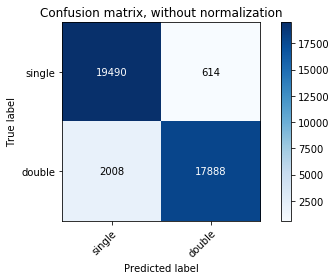

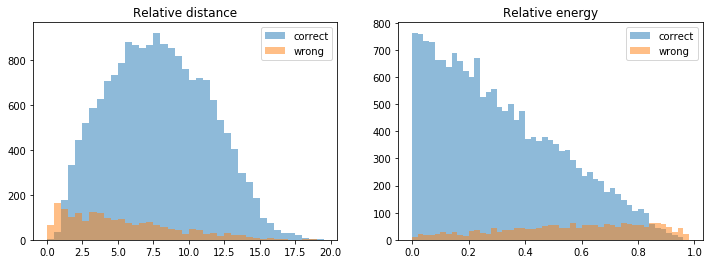

In [19]:
MODEL_PATH = "../../data/output/models/"
name = "DenseNet201-0.94.hdf5"

loaded_model = tf.keras.models.load_model(MODEL_PATH+name)

tmp_predicted = loaded_model.predict(x_test)
tmp_results = tmp_predicted.argmax(axis=-1).reshape(tmp_predicted.shape[0], 1)

# indices, relative distances and relative energies for test set
single_indices, double_indices, close_indices = event_indices(test_positions)
rel_distance = relative_distance(test_positions)
rel_energy = relative_energy(test_energies)

# Separate correct and wrong classifications


correct_doubles = np.where(tmp_results[double_indices] == 1)[0]
wrong_doubles = np.where(tmp_results[double_indices] == 0)[0]

mean_correct = np.mean(rel_distance[double_indices][correct_doubles])
mean_wrong = np.mean(rel_distance[double_indices][wrong_doubles])
mean_all = np.mean(rel_distance[double_indices])

ratio_doubles = len(correct_doubles) / len(double_indices)

# Ratio of correctly classified double events with a distance between
# events < 3mm
n_close = len(close_indices)
n_close_correct = len(np.where(rel_distance[double_indices][correct_doubles] < 3.0)[0])
ratio_close = n_close_correct / n_close
print(len(correct_doubles))
print(len(wrong_doubles))

# Output
print("Mean dist all double events: ", mean_all)
print("Mean dist correct double events: ", mean_correct)
print("Mean dist wrong double events: ", mean_wrong)
print("Ratio of correctly classified double events: ", ratio_doubles)
print("Ratio correctly classified events with dist < 3mm: ", ratio_close)

# Confusion matrix
from analysis_functions.plotting import plot_confusion_matrix
classes = ["single", "double"]
plot_confusion_matrix(y_test.argmax(axis=-1), tmp_results, classes)
plt.show()

# Histograms
dist_bins = np.arange(0, np.amax(rel_distance), 0.5)
energy_bins = np.arange(0, np.amax(rel_energy), 0.02)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(rel_distance[double_indices][correct_doubles], bins=dist_bins, alpha=0.5, label="correct")
ax[0].hist(rel_distance[double_indices][wrong_doubles], bins=dist_bins, alpha=0.5, label="wrong")
ax[0].set_title("Relative distance")
ax[0].legend()
ax[1].hist(rel_energy[double_indices][correct_doubles], bins=energy_bins, alpha=0.5, label="correct")
ax[1].hist(rel_energy[double_indices][wrong_doubles], bins=energy_bins, alpha=0.5, label="wrong")
ax[1].set_title("Relative energy")
ax[1].legend()
#ax[1,0].hist(rel_distance[double_indices], bins=50)
#ax[1,0].set_title("Distribution of relative distances")
#ax[1,1].hist(rel_energy[double_indices], bins=50)
#ax[1,1].set_title("Distribution of relative energies")
plt.show()